In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import glob

mpl.rcParams['figure.figsize'] = (5,5)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

In [2]:
model_dir = "../models/v8_shrinkwindows/"
model_name = "v8_shrinkwindows"
model_version = 1
cols = ["seed_eta", "seed_phi", "seed_iz","en_seed","et_seed",
        "cluster_deta", "cluster_dphi", "en_cluster", "et_cluster",
       "seed_f5_r9", "seed_f5_sigmaIetaIeta","seed_f5_sigmaIetaIphi","seed_f5_sigmaIphiIphi","seed_swissCross","seed_nxtals",
        "cl_f5_r9", "cl_f5_sigmaIetaIeta","cl_f5_sigmaIetaIphi","cl_f5_sigmaIphiIphi","cl_swissCross", "cl_nxtals"]
os.makedirs(model_dir, exist_ok = True)
with open("variables.txt", "w") as of:
    of.write("\n".join(cols))

# Data preparation
## Input: 
- E seed
- eta,phi,z seed
- E cluster
- delta_eta,delta_phi,

Filter only windows with the calo

In [3]:
files_ele = "/storage/ECAL/training_data/electrons/numpy_v10/training/"
files_gamma = "/storage/ECAL/training_data/gammas/numpy_v10/training/"

In [4]:
files_ele = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/electrons/numpy_v9/training/"
files_gamma = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/gammas/numpy_v9/training/"

In [4]:
datas_ele = []

for f in glob.glob(files_ele+"*.pkl"):
    d = pickle.load(open(f, "rb"))   
    datas_ele.append(d[d.is_seed == False])
    
data_ele = pd.concat(datas_ele, ignore_index=True)
data_ele["particle"] = "electron"
print("N events ele: ",len(data_ele))

datas_gamma = []
for f in glob.glob(files_gamma+"*.pkl"):
    d = pickle.load(open(f, "rb"))  
    datas_gamma.append(d[d.is_seed==False])
    
data_gamma = pd.concat(datas_gamma, ignore_index=True)
data_gamma["particle"] = "gamma"
print("N events gamma: ",len(data_gamma))

if data_ele.shape[0]> data_gamma.shape[0]:
    data = pd.concat([data_gamma, data_ele.iloc[0:len(data_gamma)]], ignore_index=True)
else:
    data = pd.concat([data_gamma.iloc[0:len(data_ele)], data_ele], ignore_index=True)
    
del data_gamma
del data_ele

N events ele:  7932037
N events gamma:  7240773


Balance gamma and electron

In [5]:
data_EB = data[abs(data.seed_eta)<1.479]
data_EE = data[abs(data.seed_eta)>=1.479]

In [6]:
print("Sample in EB:", len(data[abs(data.seed_eta) <1.479]))
print("Sample in EE:", len(data[abs(data.seed_eta) >=1.479]))
print("Sample in EB in SC:", len(data[(abs(data.seed_eta) <1.479)&(data.in_scluster)]))
print("Sample in EE in SC:", len(data[(abs(data.seed_eta) >=1.479)&(data.in_scluster)]))
print("N in supercluster: ", len(data[ data.in_scluster]))
print("N out supercluster: ", len(data[data.in_scluster == False]))
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print(w)

Sample in EB: 9605925
Sample in EE: 4875621
Sample in EB in SC: 803186
Sample in EE in SC: 444375
N in supercluster:  1247561
N out supercluster:  13233985
10.607886107372705


In [8]:
print("caloMatch samples: ", len(data[data.is_calo_matched]))
print("Not caloMatch samples: ", len(data[data.is_calo_matched ==False]))

caloMatch samples:  11639606
Not caloMatch samples:  2841940


## Check plots

In [9]:
data_in = data[ (data.is_seed == False) & data.in_scluster]
data_out =  data[(data.is_seed == False) & (data.in_scluster == False)]

## Weights by DeltaPhi

In [9]:
data = data_EE

In [46]:
inSC = len(data[(data.is_seed == False) & (data.in_scluster == True)])
data = pd.concat([data[(data.is_seed == False) & (data.in_scluster == True)],
                  data[(data.is_seed == False) & (data.in_scluster == False)].iloc[:25*inSC]])

In [10]:
X = data[ cols ].values
truth = data[["in_scluster"]].values
y = np.array(truth[:], dtype=int)
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print(w)
data["w"] = data.in_scluster.apply(lambda a: w if a else 1.)
weight = data.w.values

9.971861603375528


In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(model_dir + "/scaler_model_v{}_EB.pkl".format(model_version), "wb"))

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(model_dir+"/scaler_model_v{}_EE.pkl".format(model_version), "wb"))

In [68]:
scaler.mean_

array([-9.48937722e-02, -2.59092069e-02, -3.23802034e-02,  8.54387012e+01,
        1.95493967e+01, -7.99008024e-03,  1.68780274e-05,  8.92748605e+00,
        1.92283524e+00,  1.08804190e+00,  3.39450646e-02,  1.85485538e-05,
        4.13554904e-02,  4.96716655e-01,  5.44590774e+00,  4.09401210e+00,
        3.71462585e-02,  4.80538918e-05,  4.39461957e-02,  5.70297494e-01,
        3.15806715e+00])

In [69]:
scaler.scale_

array([2.27502784e+00, 1.80358311e+00, 9.99475624e-01, 1.25874656e+02,
       2.62122915e+01, 1.01794340e-01, 1.81101293e-01, 6.05398279e+00,
       1.77231292e+00, 5.03589571e-01, 1.40048073e-02, 4.14562658e-04,
       1.53689902e-02, 4.13270103e-01, 5.68762983e+00, 9.93354108e+00,
       1.65018741e-02, 5.45041026e-04, 1.80243836e-02, 4.37347302e-01,
       4.28826919e+00])

In [12]:
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_scaled, y, weight, test_size=0.30)

### Some plots

(array([ 879198., 1157476.,  355561.,  156087.,   99604.,   80121.,
          70304.,   65799.,   62245.,   60431.,   58162.,   57469.,
          57348.,   56096.,   55020.,   53636.,   53590.,   54743.,
          53722.,   53496.,   52947.,   53331.,   52992.,   52850.,
          51693.,   52015.,   51295.,   51462.,   51289.,   51670.,
          50930.,   50379.,   51134.,   50516.,   50429.,   49248.,
          48468.,   49130.,   48456.,   47443.,   45860.,   45847.,
          43142.,   41491.,   37639.,   33660.,   27916.,   20321.,
          12643.,    6076.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 <a list of 50 Patch objects>)

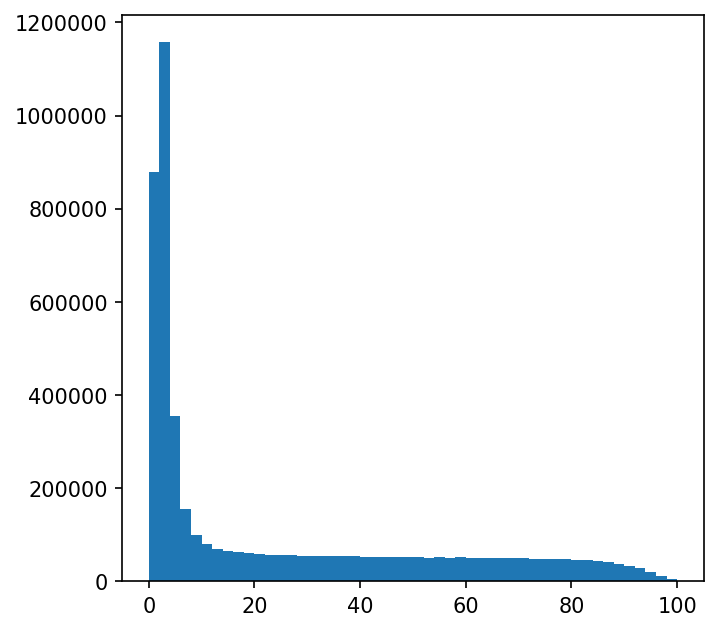

In [13]:
plt.hist(data.et_seed, bins=50, range=(0,100))

### Balancing the et regions

In [14]:
small_et = data[data.et_seed < 20].w.sum()
big_et = data[data.et_seed > 20].w.sum()

In [15]:
print(small_et)
print(big_et)

4429501.345822784
4432990.65417721


# Training

In [16]:
# Import all the required Libraries
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import callbacks
from keras import backend as K
from keras import regularizers
from keras.callbacks import *

Using TensorFlow backend.


In [17]:
model = Sequential()
model.add(Dense(100, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               2200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

In [49]:
model = Sequential()
model.add(Dense(200, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(200, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.01))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 200)               4400      
_________________________________________________________________
dropout_19 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_20 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)              

In [23]:
import math
def step_decay(epoch):
    initial_lrate = 0.4
    drop = 0.65
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if lrate < 0.002: return 0.002
    return lrate

In [18]:
auto_save = ModelCheckpoint(model_dir+ "/model_v{}_EB.hd5".format(model_version), monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=2)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=15, verbose=1)


#lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)

history = model.fit(
            X_train, y_train,
            sample_weight = w_train,
            batch_size = 4096,
            epochs=400,
            shuffle=True,
            validation_data = (X_val, y_val, w_val),
            callbacks = [early_stop, auto_save] #lr_scheduler
            )

Train on 3412934 samples, validate on 1462687 samples
Epoch 1/400
3412934/3412934 [==============================] - 14s 4us/step - loss: 0.4563 - accuracy: 0.9295 - val_loss: 0.3108 - val_accuracy: 0.9358
Epoch 2/400
3412934/3412934 [==============================] - 14s 4us/step - loss: 0.3018 - accuracy: 0.9405 - val_loss: 0.2852 - val_accuracy: 0.9518

Epoch 00002: val_loss improved from inf to 0.28522, saving model to ../models/v8_shrinkwindows//model_v1_EB.hd5
Epoch 3/400
3412934/3412934 [==============================] - 14s 4us/step - loss: 0.2822 - accuracy: 0.9431 - val_loss: 0.2682 - val_accuracy: 0.9421
Epoch 4/400
3412934/3412934 [==============================] - 14s 4us/step - loss: 0.2734 - accuracy: 0.9445 - val_loss: 0.2645 - val_accuracy: 0.9414

Epoch 00004: val_loss improved from 0.28522 to 0.26450, saving model to ../models/v8_shrinkwindows//model_v1_EB.hd5
Epoch 5/400
3412934/3412934 [==============================] - 14s 4us/step - loss: 0.2672 - accuracy: 0.945

Epoch 42/400
3412934/3412934 [==============================] - 14s 4us/step - loss: 0.2357 - accuracy: 0.9501 - val_loss: 0.2329 - val_accuracy: 0.9458

Epoch 00042: val_loss did not improve from 0.23235
Epoch 43/400
3412934/3412934 [==============================] - 14s 4us/step - loss: 0.2355 - accuracy: 0.9503 - val_loss: 0.2347 - val_accuracy: 0.9419
Epoch 44/400
3412934/3412934 [==============================] - 14s 4us/step - loss: 0.2354 - accuracy: 0.9502 - val_loss: 0.2322 - val_accuracy: 0.9484

Epoch 00044: val_loss improved from 0.23235 to 0.23220, saving model to ../models/v8_shrinkwindows//model_v1_EB.hd5
Epoch 45/400
3412934/3412934 [==============================] - 14s 4us/step - loss: 0.2349 - accuracy: 0.9503 - val_loss: 0.2405 - val_accuracy: 0.9634
Epoch 46/400
3412934/3412934 [==============================] - 14s 4us/step - loss: 0.2348 - accuracy: 0.9503 - val_loss: 0.2414 - val_accuracy: 0.9637

Epoch 00046: val_loss did not improve from 0.23220
Epoch 47/400
3

3412934/3412934 [==============================] - 14s 4us/step - loss: 0.2295 - accuracy: 0.9511 - val_loss: 0.2266 - val_accuracy: 0.9559

Epoch 00086: val_loss improved from 0.22753 to 0.22662, saving model to ../models/v8_shrinkwindows//model_v1_EB.hd5
Epoch 87/400
3412934/3412934 [==============================] - 14s 4us/step - loss: 0.2293 - accuracy: 0.9510 - val_loss: 0.2302 - val_accuracy: 0.9474
Epoch 88/400
3412934/3412934 [==============================] - 14s 4us/step - loss: 0.2297 - accuracy: 0.9509 - val_loss: 0.2257 - val_accuracy: 0.9517

Epoch 00088: val_loss improved from 0.22662 to 0.22569, saving model to ../models/v8_shrinkwindows//model_v1_EB.hd5
Epoch 89/400
3412934/3412934 [==============================] - 14s 4us/step - loss: 0.2294 - accuracy: 0.9509 - val_loss: 0.2485 - val_accuracy: 0.9679
Epoch 90/400
3412934/3412934 [==============================] - 14s 4us/step - loss: 0.2292 - accuracy: 0.9510 - val_loss: 0.2292 - val_accuracy: 0.9576

Epoch 00090: 

In [50]:
auto_save = ModelCheckpoint(model_dir+ "/model_v{}_EE.hd5".format(model_version) , monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=3)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=10, verbose=1)


#lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)

history = model.fit(
            X_train, y_train,
            sample_weight = w_train,
            batch_size = 4096,
            epochs=400,
            shuffle=True,
            validation_data = (X_val, y_val, w_val),
            callbacks = [early_stop, auto_save, ] #lr_scheduler
            )

Train on 9323759 samples, validate on 3995898 samples
Epoch 1/400
9323759/9323759 [==============================] - 45s 5us/step - loss: 0.2955 - accuracy: 0.9560 - val_loss: 0.2166 - val_accuracy: 0.9659
Epoch 2/400
9323759/9323759 [==============================] - 44s 5us/step - loss: 0.2095 - accuracy: 0.9629 - val_loss: 0.1975 - val_accuracy: 0.9709
Epoch 3/400
9323759/9323759 [==============================] - 44s 5us/step - loss: 0.2000 - accuracy: 0.9636 - val_loss: 0.1922 - val_accuracy: 0.9671

Epoch 00003: val_loss improved from inf to 0.19218, saving model to ../models/v7_detseparated//model_1_EE.hd5
Epoch 4/400
9323759/9323759 [==============================] - 44s 5us/step - loss: 0.1954 - accuracy: 0.9639 - val_loss: 0.1994 - val_accuracy: 0.9504
Epoch 5/400
9323759/9323759 [==============================] - 44s 5us/step - loss: 0.1920 - accuracy: 0.9641 - val_loss: 0.1914 - val_accuracy: 0.9743
Epoch 6/400
9323759/9323759 [==============================] - 44s 5us/step


Epoch 00045: val_loss did not improve from 0.16799
Epoch 46/400
9323759/9323759 [==============================] - 44s 5us/step - loss: 0.1715 - accuracy: 0.9666 - val_loss: 0.1667 - val_accuracy: 0.9700
Epoch 47/400
9323759/9323759 [==============================] - 44s 5us/step - loss: 0.1716 - accuracy: 0.9665 - val_loss: 0.1714 - val_accuracy: 0.9737
Epoch 48/400
9323759/9323759 [==============================] - 44s 5us/step - loss: 0.1710 - accuracy: 0.9666 - val_loss: 0.1669 - val_accuracy: 0.9664

Epoch 00048: val_loss improved from 0.16799 to 0.16693, saving model to ../models/v7_detseparated//model_1_EE.hd5
Epoch 49/400
9323759/9323759 [==============================] - 44s 5us/step - loss: 0.1713 - accuracy: 0.9664 - val_loss: 0.1659 - val_accuracy: 0.9670
Epoch 50/400
9323759/9323759 [==============================] - 44s 5us/step - loss: 0.1709 - accuracy: 0.9666 - val_loss: 0.1666 - val_accuracy: 0.9648
Epoch 51/400
9323759/9323759 [==============================] - 44s 

>>> Computing AUC...
AUC score: 0.9913593398361924
>>> Saving ROC curve...


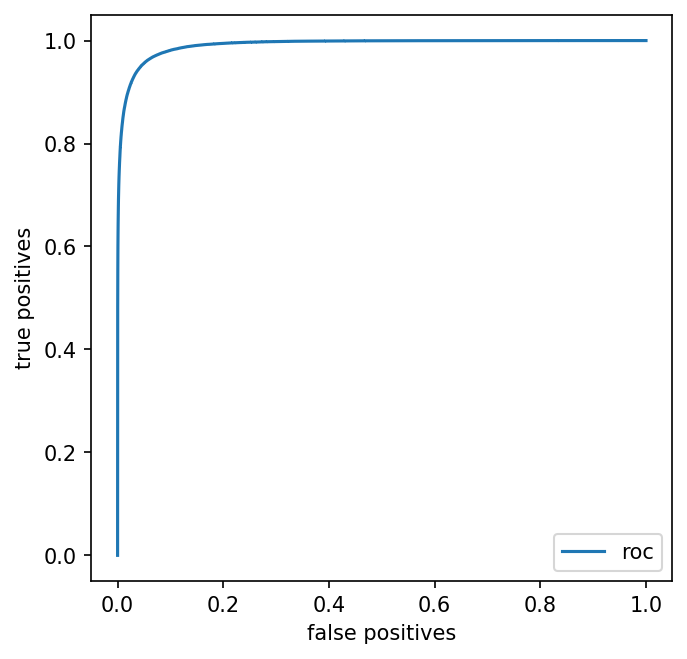

In [19]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_val,batch_size=2048)
auc = roc_auc_score(y_val, pred, sample_weight=w_val)
print("AUC score: " + str(auc))

print(">>> Saving ROC curve...")
fp , tp, th = roc_curve(y_val, pred, sample_weight=w_val,drop_intermediate=True)
plt.plot(fp, tp, label="roc")
#plt.plot(fp, th, label="threshold")
plt.xlabel("false positives")
plt.ylabel("true positives")
plt.ylim(-0.05,1.05)

plt.legend()

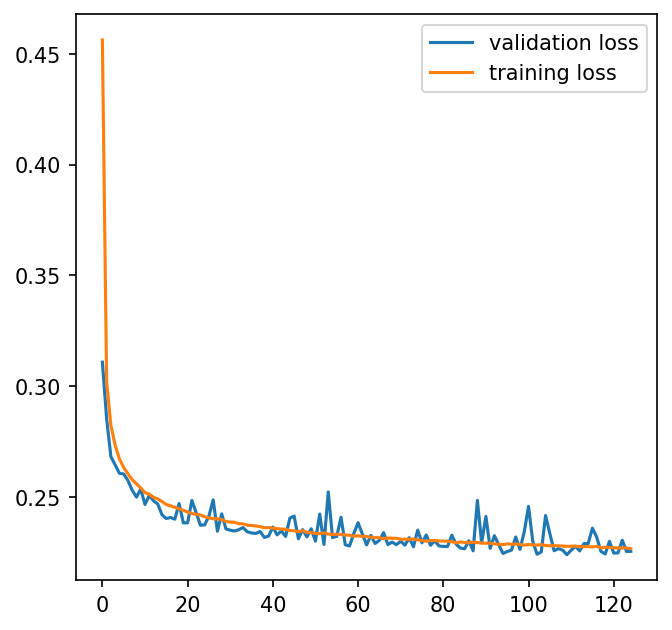

In [20]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

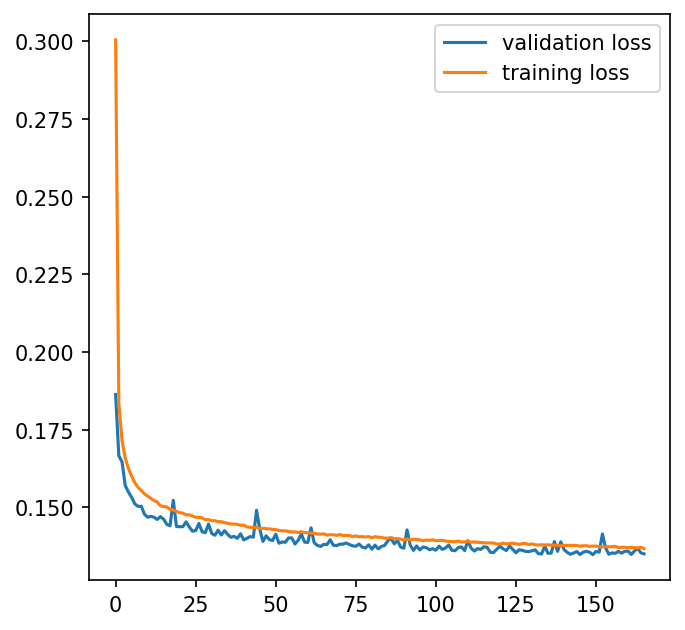

In [64]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

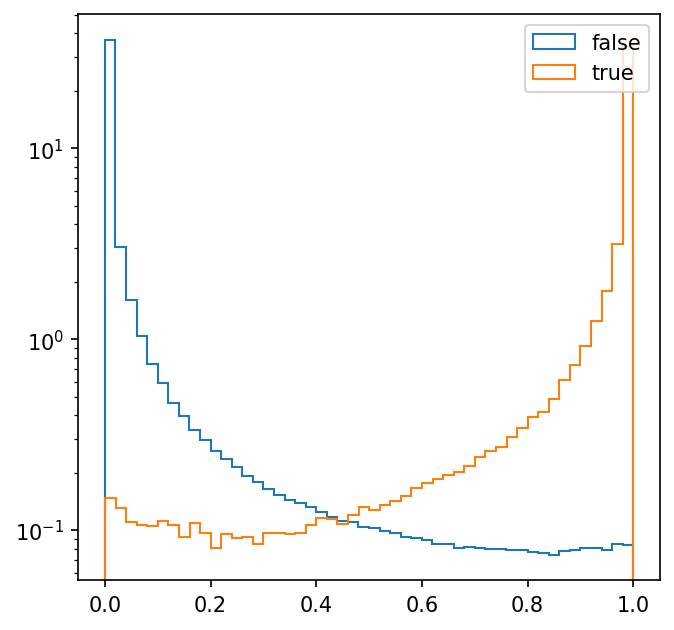

In [21]:
results = model.predict(X_val)
plt.hist(results[y_val==0], bins=50,density=True, label="false", histtype="step")
plt.hist(results[y_val==1], bins=50, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

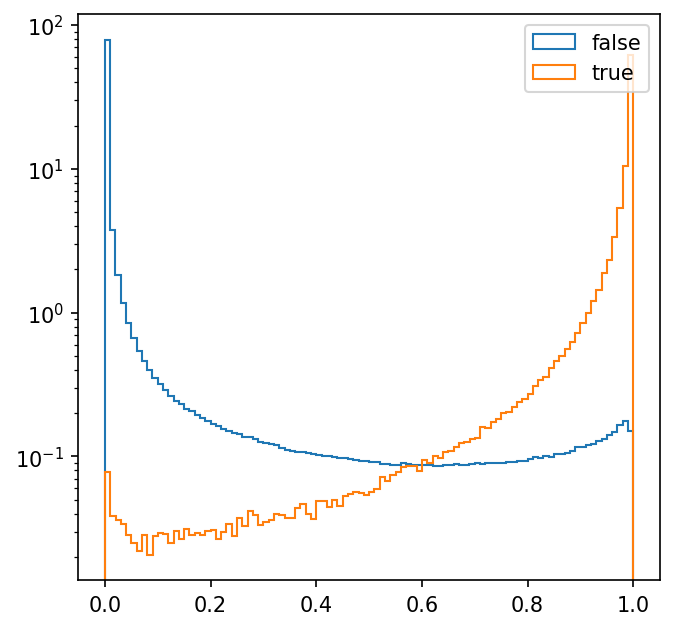

In [42]:
results = model.predict(X_val)
plt.hist(results[y_val==0], bins=100,density=True, label="false", histtype="step")
plt.hist(results[y_val==1], bins=100, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

In [34]:
plt.savefig(model_dir +"/output_model_v1_EB.png")

<Figure size 750x750 with 0 Axes>

# Some plots

In [1]:
from keras.models import load_model
model = load_model("models/model11_balanced_100_80_50.hd5")
scaler = pickle.load(open("models/scaler_gamma_electrons.pkl", "rb"))

Using TensorFlow backend.


OSError: Unable to open file (unable to open file: name = 'models/model11_balanced_100_80_50.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [27]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()

NameError: name 'y_test' is not defined

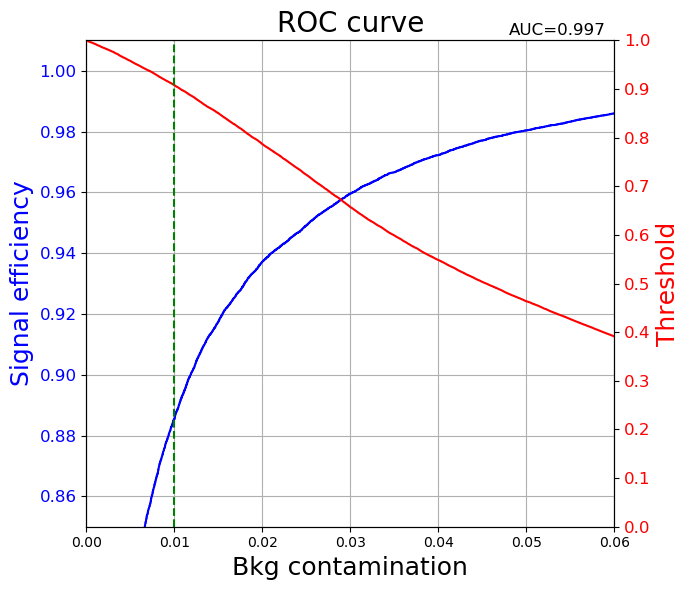

In [36]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()